In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
import SimpleITK as sitk
import cv2 as cv

In [4]:
location = 'H:/All Files/Kaggle/Bacteria/Train_Images/'
train = os.listdir(location)
np.shape(train)

(606,)

In [5]:
data = pd.read_excel('H:/All Files/Kaggle/Bacteria/TrainImageLabels.xlsx')
data.head(10)

,Image ID,Class
0,4,ecoli
1,5,salmonella
2,14,staphylococus
3,15,listeria
4,16,ecoli
5,21,ecoli
6,22,salmonella
7,23,staphylococus
8,24,ecoli
9,26,salmonella


In [6]:
data.pivot_table(index='Class',aggfunc=len).sort_values('Image ID',ascending=False)

#Checking number of bacteria per class

,Image ID
Class,
listeria,153
salmonella,153
ecoli,150
staphylococus,150


In [7]:
from sklearn.preprocessing import LabelEncoder

label1=LabelEncoder()
data['Class'] = label1.fit_transform(data['Class'])

data.head()

,Image ID,Class
0,4,0
1,5,2
2,14,3
3,15,1
4,16,0


0 = ecoli, 1 = listeria, 2 = salmonella , 3 = staphylococus

In [8]:
image_size = 512

def loadDataTrain(data, location):

    images = []
    labels = []
    name = []

    for i, item in data.iterrows():
        image_raw = cv.imread(os.path.join(location + str(item[0]) + '.png'))
        image_resize = cv.resize(image_raw,(image_size,image_size))
        image = image_resize/255.0
        
        image_name = str(item[0])
        
        label = data['Class'].values[i]
        
        
        images.append(image)
        labels.append(label)
        name.append(image_name)
               
    images = np.array(images)
    labels = np.array(labels)
    name = np.array(name)
    
    return images,labels,name

In [9]:
X,y,n = loadDataTrain(data,location)

In [10]:
X.shape

(606, 512, 512, 3)

In [11]:
y.shape

(606,)

In [12]:
n.shape

(606,)

In [13]:
y_new = np.expand_dims(y,axis=1)
x_new = np.array(X).reshape(-1, image_size, image_size, 3)
print (x_new.shape)
print (y_new.shape)

(606, 512, 512, 3)
(606, 1)


In [14]:
bacteria_names = ['Ecoli', 'Listeria', 'Salmonella', 'Staphylococus']

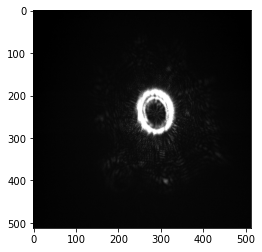

Salmonella
520


In [15]:
import random

m = random.randint(0,X.shape[0]-1)

plt.imshow(X[m])
plt.show()

if y[m]==0:
    print(bacteria_names[0])
elif y[m] ==1:
    print(bacteria_names[1])
elif y[m]==2:
    print(bacteria_names[2])
else:
    print(bacteria_names[3])
    
print(n[m])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_new,y_new, test_size=0.1, random_state=32)

In [17]:
X_train.shape

(545, 512, 512, 3)

In [18]:
X_test.shape

(61, 512, 512, 3)

In [19]:
y_train.shape

(545, 1)

In [20]:
y_test.shape

(61, 1)

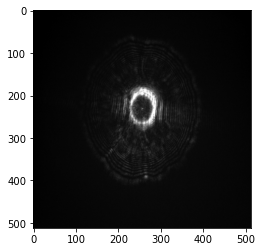

[3]


In [21]:
import random

l = random.randint(0,X_train.shape[0]-1)

plt.imshow(X_train[l])
plt.show()
print(y_train[l])

In [22]:
i = Input(X_train.shape[1:])

a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)
a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)
a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Flatten()(a)
a = Dense(1024, activation = 'relu')(a)
a = Dropout(0.2)(a)
a = Dense(1024, activation = 'relu')(a)
a = Dropout(0.1)(a)

a = Dense(4, activation = 'softmax')(a)

model = Model(i,a)

In [23]:
model.compile(optimizer = 'adam' ,loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256   

In [24]:
data_generator = ImageDataGenerator(horizontal_flip =True,
                                    vertical_flip =True,
                                    width_shift_range = 0.1, 
                                    height_shift_range = 0.1, 
                                    rotation_range = 10, 
                                    rescale = 1.0, 
                                    zoom_range = 0.2,
                                    fill_mode='nearest',
                                   cval=0)

In [25]:
batch_size = 4

train_gen = data_generator.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Bacteria1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

In [27]:
r = model.fit(train_gen, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs= 15,
                       callbacks = [checkpoint])

  ...
    to  
  ['...']
Train for 136 steps, validate on 61 samples
Epoch 1/15
135/136 [============================>.] - ETA: 0s - loss: 20.3574 - accuracy: 0.3222
Epoch 00001: val_accuracy improved from -inf to 0.22951, saving model to Bacteria1.h5
136/136 [==============================] - 45s 333ms/step - loss: 20.2678 - accuracy: 0.3216 - val_loss: 31.5668 - val_accuracy: 0.2295
Epoch 2/15
135/136 [============================>.] - ETA: 0s - loss: 6.2076 - accuracy: 0.3575
Epoch 00002: val_accuracy did not improve from 0.22951
136/136 [==============================] - 33s 244ms/step - loss: 6.1656 - accuracy: 0.3604 - val_loss: 7.6417 - val_accuracy: 0.2295
Epoch 3/15
135/136 [============================>.] - ETA: 0s - loss: 3.4498 - accuracy: 0.3706
Epoch 00003: val_accuracy improved from 0.22951 to 0.29508, saving model to Bacteria1.h5
136/136 [==============================] - 37s 271ms/step - loss: 3.4662 - accuracy: 0.3678 - val_loss: 2.3342 - val_accuracy: 0.2951
Epoch 4/

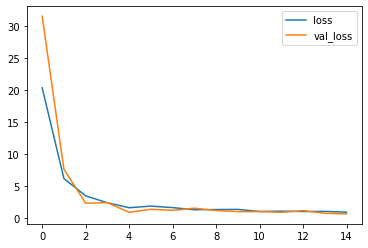

In [28]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [30]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
new_model = tf.keras.models.load_model('Bacteria1.h5')

In [31]:
new_model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

checkpoint1 = ModelCheckpoint('Bacteria2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

batch_size = 4

r1 = new_model.fit(train_gen, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs= 15,
                       callbacks = [checkpoint1])

  ...
    to  
  ['...']
Train for 136 steps, validate on 61 samples
Epoch 1/15
135/136 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.7449
Epoch 00001: val_accuracy improved from -inf to 0.88525, saving model to Bacteria2.h5
136/136 [==============================] - 36s 262ms/step - loss: 0.6415 - accuracy: 0.7449 - val_loss: 0.4243 - val_accuracy: 0.8852
Epoch 2/15
135/136 [============================>.] - ETA: 0s - loss: 0.6361 - accuracy: 0.7561
Epoch 00002: val_accuracy did not improve from 0.88525
136/136 [==============================] - 31s 229ms/step - loss: 0.6333 - accuracy: 0.7560 - val_loss: 0.4460 - val_accuracy: 0.8852
Epoch 3/15
135/136 [============================>.] - ETA: 0s - loss: 0.5332 - accuracy: 0.7803
Epoch 00003: val_accuracy improved from 0.88525 to 0.95082, saving model to Bacteria2.h5
136/136 [==============================] - 64s 468ms/step - loss: 0.5308 - accuracy: 0.7819 - val_loss: 0.3894 - val_accuracy: 0.9508
Epoch 4/15


In [33]:
new_model.compile(optimizer = Adam(lr = 1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

checkpoint2 = ModelCheckpoint('Bacteria3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

batch_size = 4

train_gen = data_generator.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

r1 = new_model.fit(train_gen, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint2])

  ...
    to  
  ['...']
Train for 136 steps, validate on 61 samples
Epoch 1/10
135/136 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9553
Epoch 00001: val_accuracy improved from -inf to 0.98361, saving model to Bacteria3.h5
136/136 [==============================] - 36s 262ms/step - loss: 0.1149 - accuracy: 0.9556 - val_loss: 0.0769 - val_accuracy: 0.9836
Epoch 2/10
135/136 [============================>.] - ETA: 0s - loss: 0.0839 - accuracy: 0.9758
Epoch 00002: val_accuracy did not improve from 0.98361
136/136 [==============================] - 31s 228ms/step - loss: 0.0836 - accuracy: 0.9760 - val_loss: 0.0775 - val_accuracy: 0.9836
Epoch 3/10
135/136 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9739
Epoch 00003: val_accuracy did not improve from 0.98361
136/136 [==============================] - 31s 229ms/step - loss: 0.0865 - accuracy: 0.9723 - val_loss: 0.0680 - val_accuracy: 0.9836
Epoch 4/10
135/136 [=========================

In [27]:
final_model = tf.keras.models.load_model('Bacteria3.h5')

In [28]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [29]:
P= final_model.predict(X_test, batch_size = 4).argmax(axis=1)
print(P)

[2 0 1 1 3 3 0 2 1 0 3 3 2 1 1 0 0 2 0 3 2 0 2 2 3 0 3 0 2 3 0 3 2 0 2 2 1
 2 1 3 0 2 0 0 1 1 2 2 3 2 0 3 0 2 1 2 3 0 3 2 0]


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29eae574588>)

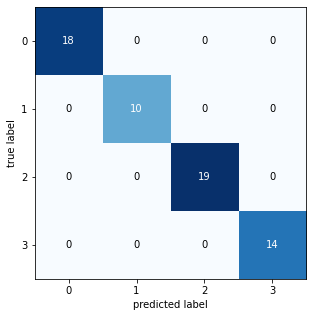

In [30]:
matrix = confusion_matrix (y_test, P)
plot_confusion_matrix(matrix, figsize=(5,5))

In [31]:
def perf_measure(y_test, P):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(P)): 
        if y_test[i]==P[i]==1:
           TP += 1
        if y_test[i]==1 and y_test[i]!=P[i]:
           FP += 1
        if y_test[i]==P[i]==0:
           TN += 1
        if y_test[i]==0 and y_test[i]!=P[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [32]:
tp, fp, tn ,fn = perf_measure(y_test,P)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 1.00
Precision of the model is 1.00
F-Score is 1.00


## Final Classification

In [33]:
location_test = 'H:/All Files/Kaggle/Bacteria/Test_Images/'
test = os.listdir(location_test)
np.shape(test)

(1227,)

In [34]:
df = pd.read_csv('H:/All Files/Kaggle/Bacteria/SubmissionFile.csv')
df.head(10)

,Image ID,Class
0,2,NaN
1,6,NaN
2,7,NaN
3,8,NaN
4,9,NaN
5,10,NaN
6,11,NaN
7,12,NaN
8,13,NaN
9,17,NaN


In [65]:
def loadDataTest(df, location):

    labels = []
  
    for i, item in df.iterrows():
        image_raw = cv.imread(os.path.join(location_test + str(int(item[0])) + '.png'))
        image_resize = cv.resize(image_raw,(image_size,image_size))
        image_unshaped = image_resize/255.0
        image = np.array(image_unshaped).reshape(-1, image_size, image_size, 3)
        
        
        label = final_model.predict(image).argmax(axis=1)
                                    
        if label==0:
            label = bacteria_names[0]
        elif label ==1:
            label = bacteria_names[1]
        elif label==2:
            label = bacteria_names[2]
        else:
            label = bacteria_names[3]
            
        labels.append(label)
        
                                    
    return labels 

In [66]:
final_csv = pd.DataFrame(data = loadDataTest(df,location_test))

In [67]:
final_csv.head(25)

,0
0,Staphylococus
1,Salmonella
2,Ecoli
3,Ecoli
4,Ecoli
5,Ecoli
6,Staphylococus
7,Staphylococus
8,Ecoli
9,Salmonella


In [68]:
df['Class'] = final_csv

In [69]:
df

,Image ID,Class
0,2,Staphylococus
1,6,Salmonella
2,7,Ecoli
3,8,Ecoli
4,9,Ecoli
...,...,...
1222,1996,Ecoli
1223,1997,Salmonella
1224,1998,Listeria
1225,1999,Staphylococus


In [71]:
df.to_excel('Bacteria_Classification_Predictions.xlsx')